# Training
on entraine le réseau de neurones pour les hyperparamètres

In [1]:
# importation
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# local
from MyResNet.myfunc import Physics
from MyResNet.myfunc import MyMatmul
from MyResNet.model import MyModel

### Paramètres physiques

In [2]:
a = 1
p = 1
nx = 200
Trsf, tensor_list = Physics(a,p,nx)
Tt          = MyMatmul(Trsf.T)
mass        = 1
U           = torch.FloatTensor(np.ones(nx))

In [3]:
def CreateLoader(folder,nsample):
    """
    According to the mode, creates the appropriate loader 
    for the training and validation sets.
    """
    dfx     = pd.read_csv(folder+'/'+'data_lisse.csv', sep=',',header=None)
    dfy     = pd.read_csv(folder+'/'+'data_blurred.csv', sep=',',header=None)
    _,nx    = dfx.shape
    #
    x_tensor= torch.FloatTensor(dfx.values[:nsample]).view(-1,1,nx)
    y_tensor= torch.FloatTensor(dfy.values[:nsample]).view(-1,1,nx)
    #
    dataset = TensorDataset(x_tensor, y_tensor)
    l = len(dataset)
    m = 2*l//3
    train_dataset, val_dataset = random_split(dataset, [m, l-m])
    #
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)
    return train_loader, val_loader

In [4]:
folder  = './MyResNet/Dataset'
nsample = 50
t, v    = CreateLoader(folder)

### Model

In [5]:
mymodel = MyModel(tensor_list,mass,U,50)

In [6]:
loss_fn = nn.MSELoss(reduction='mean')

### Training

In [7]:
def train(model,nb_epochs):
    """
    Trains iRestNet.
    """      
    # to store results
    loss_train   =  np.zeros(nb_epochs)
    loss_val     =  np.zeros(nb_epochs)
    loss_min_val =  float('Inf')
    # defines the optimizer
    lr_i        = 0.01
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=lr_i)

    #==========================================================================================================
    # trains for several epochs
    for epoch in range(0,nb_epochs): 
        # sets training mode
        model.train()
        # modifies learning rate
        if epoch>0:
            lr_i      = lr_i*0.9 
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()), lr=lr_i)
        # TRAINING
        # goes through all minibatches
        for i,minibatch in enumerate(t):
            [x_true, x_blurred] = minibatch    # get the minibatch
            x_true    = Variable(x_true,requires_grad=False)
            x_init    = Variable(x_blurred,requires_grad=False)
            # ATTENTION : on ne calcule pas le gradient en fonction de la deuxième sortie (à réfléchir)
            Ttx_init  = Tt(x_init).detach()     # do not compute gradient
            x_pred    = model(x_init,Ttx_init) 
                    
            # Computes and prints loss
            loss                = loss_fn(x_pred, x_true)
            loss_train[epoch] += torch.Tensor.item(loss)
                    
            # sets the gradients to zero, performs a backward pass, and updates the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # normalisation
        loss_train[epoch] = loss_train[epoch]/i
        #
        #
        # VALIDATION AND STATS
        if epoch%1==0:
            with torch.no_grad():
            # saves signal and model state  
            # utils.save_image(x_pred.data,os.path.join(
            #            folder,'training',str(epoch)+'_restored_images.png'),normalize=True)
            # torch.save(self.last_layer.state_dict(),os.path.join(folder,'trained_post-processing.pt'))
            # torch.save(self.model.state_dict(),os.path.join(folder,'trained_model.pt'))

            # tests on validation set
                model.eval()      # evaluation mode
                for i,minibatch in enumerate(v):
                    [x_true, x_blurred] = minibatch            # gets the minibatch
                    x_true    = Variable(x_true,requires_grad=False)
                    x_init    = Variable(x_blurred,requires_grad=False)
                    Tt_x_init = Tt(x_init).detach()        # does not compute gradient
                    x_pred = model(x_init,Tt_x_init) 
                    
                    # computes loss on validation set
                    loss_val[epoch] += torch.Tensor.item(loss_fn(x_pred, x_true))
                # normalisation
                loss_val[epoch] = loss_val[epoch]/i
            # print stat
            print("epoch : ", epoch," ----- ","validation : ",loss_val[epoch])


               
               
            
    #==========================================================================================================
    # training is finished
    print('-----------------------------------------------------------------')
    print('Training is done.')
    print('-----------------------------------------------------------------')

    return loss_train, loss_val

In [8]:
loss_t, loss_v = train(mymodel,10)

epoch :  0  -----  validation :  0.20811302494257689
epoch :  1  -----  validation :  0.1270219716243446
epoch :  2  -----  validation :  0.05151138245128095
epoch :  3  -----  validation :  0.048395801801234484
epoch :  4  -----  validation :  0.04640241526067257
epoch :  5  -----  validation :  0.044842072296887636
epoch :  6  -----  validation :  0.04355656704865396
epoch :  7  -----  validation :  0.042313115671277046
epoch :  8  -----  validation :  0.041018193238414824
epoch :  9  -----  validation :  0.04037229320965707
-----------------------------------------------------------------
Training is done.
-----------------------------------------------------------------


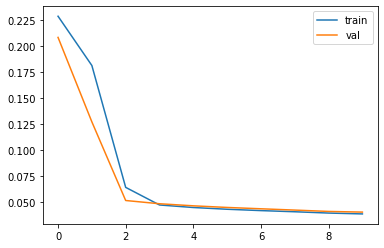

In [9]:
plt.plot(loss_t,label = 'train')
plt.plot(loss_v,label = 'val')
plt.legend()

### Plot of trained model

In [10]:
x_pred = []
x_ref  = []
x_b    = []
for i,minibatch in enumerate(v):
    [x_true, x_blurred] = minibatch    # get the minibatch
    x_true    = Variable(x_true,requires_grad=False)
    x_init    = Variable(x_blurred,requires_grad=False)
    # ATTENTION : on ne calcule pas le gradient en fonction de la deuxième sortie (à réfléchir)
    Ttx_init  = Tt(x_init).detach()     # do not compute gradient
    x_pred.append(mymodel(x_init,Ttx_init).detach())
    x_ref.append(x_true.detach())
    x_b.append(x_init.detach())

In [11]:
#x_pred = mymodel(x_init,Ttx_init,save_gamma_mu_lambda='yes').detach()

In [12]:
len(x_pred)

17

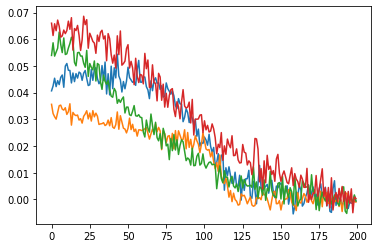

In [13]:
plt.plot(x_b[1].squeeze().numpy())
plt.plot(x_b[2].squeeze().numpy())
plt.plot(x_b[11].squeeze().numpy())
plt.plot(x_b[12].squeeze().numpy())

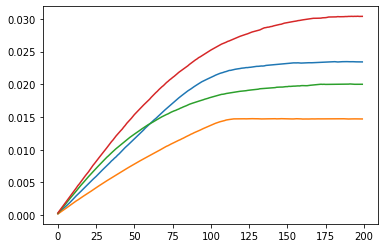

In [14]:
plt.plot(Tt(x_b[1]).squeeze().numpy())
plt.plot(Tt(x_b[2]).squeeze().numpy())
plt.plot(Tt(x_b[11]).squeeze().numpy())
plt.plot(Tt(x_b[12]).squeeze().numpy())

In [15]:
Tt(x_b[1]).squeeze()[0]
Tt(x_b[2]).squeeze()[0]
Tt(x_b[3]).squeeze()[0]

tensor(0.0001)

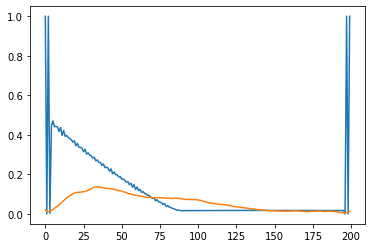

In [16]:
plt.plot(x_pred[11].squeeze().numpy())
plt.plot(x_ref[11].squeeze().numpy())

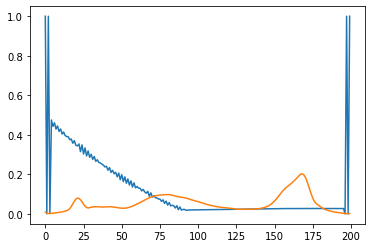

In [17]:
plt.plot(x_pred[10].squeeze().numpy())
plt.plot(x_ref[10].squeeze().numpy())

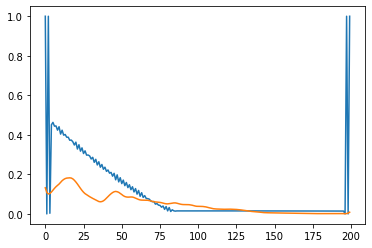

In [18]:
plt.plot(x_pred[15].squeeze().numpy())
plt.plot(x_ref[15].squeeze().numpy())

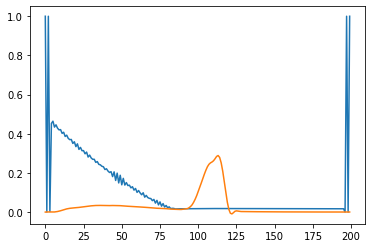

In [19]:
plt.plot(x_pred[2].squeeze().numpy())
plt.plot(x_ref[2].squeeze().numpy())

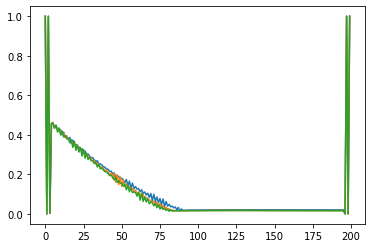

In [20]:
plt.plot(x_pred[1].squeeze().numpy())
plt.plot(x_pred[2].squeeze().numpy())
plt.plot(x_pred[3].squeeze().numpy())

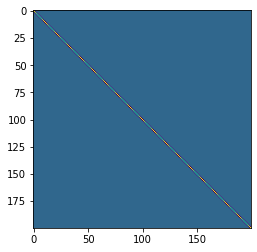

In [21]:
D  = nx**2*(2*np.diag(np.ones(nx)) - np.diag(np.ones(nx-1),-1) - np.diag(np.ones(nx-1),1))# matrice de dérivation
Top  = 1/nx*np.tri(nx, nx, 0, dtype=int).T # matrice de convolution
plt.imshow(D)

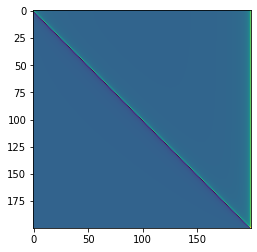

In [22]:
from scipy.linalg import sqrtm
D1 = sqrtm(D)
plt.imshow(Top.dot(D1))

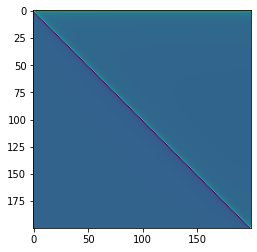

In [23]:
plt.imshow(D1.dot(Top))

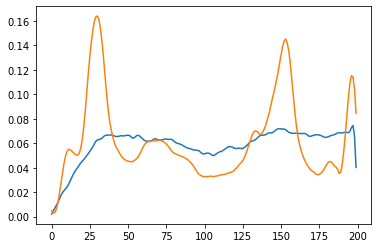

In [24]:
alpha = 0.00000000001
rho = 1
xk  = np.zeros(nx)
Ttx = Tt(x_b[5]).squeeze().numpy()
for k in range(50):
    xk -=rho*((Top.T.dot(Top)).dot(xk)-Ttx+alpha*(D.T).dot(D).dot(xk))
              
plt.plot(xk)
plt.plot(x_ref[5].squeeze().numpy())